In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet, tanh

In [2]:
import sys
import os

collocation_path = os.path.abspath(os.path.join('..', 'collocation'))

# Add the directory to sys.path
if collocation_path not in sys.path:
    sys.path.append(collocation_path)

from collocation_improved import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation

### (Pyomo + ipopt) -> predicting parameters of a neural network

In [3]:
#-------------------------------------NODE SET UP----------------------------------#
#-----------------------------------DATA GENERATION--------------------------------#
#------------------------------------COLLOCATION MATRIX----------------------------#
#-----------------------------------MODEL CREATION---------------------------------#
#---------------------------------NEURAL NET PARAMS--------------------------------#
#-----------------------------------FORWARD PASS-----------------------------------#
#--------------------------------INITIAL CONDITIONS--------------------------------#
#------------------------------------CONSTRAINTS-----------------------------------#
#-----------------------------OBJECTIVE FUNCTION DEFINITION------------------------#
#--------------------------------SOLVING THE MODEL---------------------------------#

In [42]:
#---------------------------NODE SET UP--------------------------#
omega = 1.0
T = 1.0
N = 10

interpolant = BarycentricInterpolation(N, 0, T)
t_grid = np.array(interpolant.nodes)

#---------------------------DATA GENERATION------------------------#
true_u = np.cos(omega * t_grid)
true_v = -omega * np.sin(omega * t_grid)

# Add some noise to simulate real-world data
data_u = true_u + 0.00 * np.random.randn(N)
data_v = true_v + 0.00 * np.random.randn(N)

#---------------------------COLLOCATION MATRIX---------------------#
weights = compute_weights(t_grid)
D = lagrange_derivative(t_grid, weights)
D = np.array(D)

In [43]:
#-----------------------------------MODEL CREATION---------------------------------#
n_hidden = 20  # Number of neurons in hidden layer

model = ConcreteModel()
model.t_idx = RangeSet(0, N-1)

#---------------------------------NEURAL NET PARAMS--------------------------------#
model.W1 = Var(range(n_hidden), initialize=0.1)
model.b1 = Var(initialize=0.1)
model.W2_u = Var(range(n_hidden), initialize=0.1)
model.W2_v = Var(range(n_hidden), initialize=0.1)
model.b2_u = Var(initialize=0.1)
model.b2_v = Var(initialize=0.1)

#-----------------------------------FORWARD PASS-----------------------------------#
def neural_net(m, t):
    z = sum(m.W1[j] * t + m.b1 for j in range(n_hidden))
    a = tanh(z)
    u = sum(m.W2_u[j] * a for j in range(n_hidden)) + m.b2_u
    v = sum(m.W2_v[j] * a for j in range(n_hidden)) + m.b2_v
    return u, v

#--------------------------------INITIAL CONDITIONS--------------------------------#
model.initial_conditions = ConstraintList()
model.initial_conditions.add(neural_net(model, t_grid[0])[0] == true_u[0])
model.initial_conditions.add(neural_net(model, t_grid[0])[1] == true_v[0])

#------------------------------------CONSTRAINTS-----------------------------------#
model.ode_constraints = ConstraintList()
for i in model.t_idx:
    # Neural network outputs for u and v at the current collocation point
    u_nn, v_nn = neural_net(model, t_grid[i])
    
    du_dt = sum(D[i, j] * neural_net(model, t_grid[j])[0] for j in model.t_idx)
    dv_dt = sum(D[i, j] * neural_net(model, t_grid[j])[1] for j in model.t_idx)
    
    model.ode_constraints.add(du_dt == v_nn)
    model.ode_constraints.add(dv_dt == -omega**2 * u_nn)

#-----------------------------OBJECTIVE FUNCTION DEFINITION------------------------#
def _objective(m):
    return sum((neural_net(m, t_grid[i])[0] - data_u[i])**2 + (neural_net(m, t_grid[i])[1] - data_v[i])**2 for i in m.t_idx)

model.obj = Objective(rule=_objective, sense=pyo.minimize)

#--------------------------------SOLVING THE MODEL---------------------------------#
solver = SolverFactory('ipopt')
solver.options['max_iter'] = 10000
solver.options['tol'] = 1e-6
solver.options['max_cpu_time'] = 300.0
results = solver.solve(model, tee=True)

if results.solver.termination_condition != pyo.TerminationCondition.optimal:
    print(f"Warning: Solver did not find an optimal solution. Termination condition: {results.solver.termination_condition}")

Ipopt 3.14.16: max_iter=10000
tol=1e-06
max_cpu_time=300.0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     1304
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1575

Total number of variables............................:       63
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constra

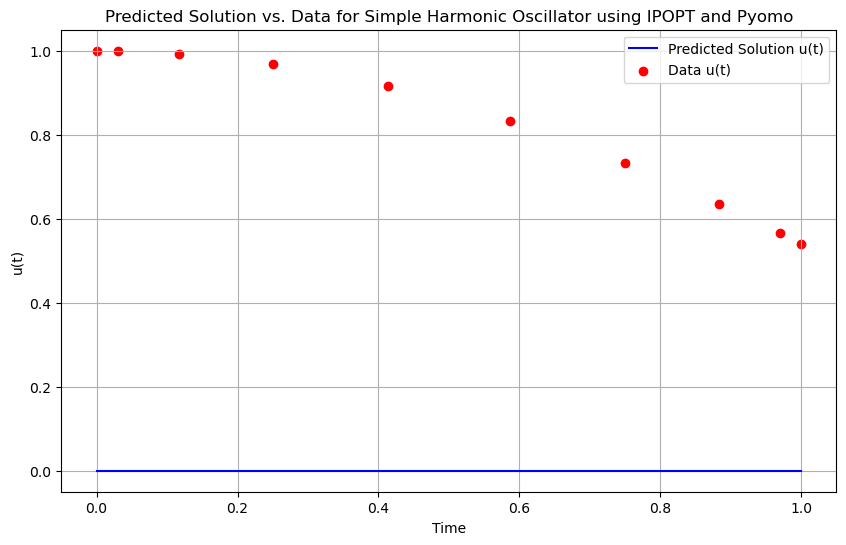

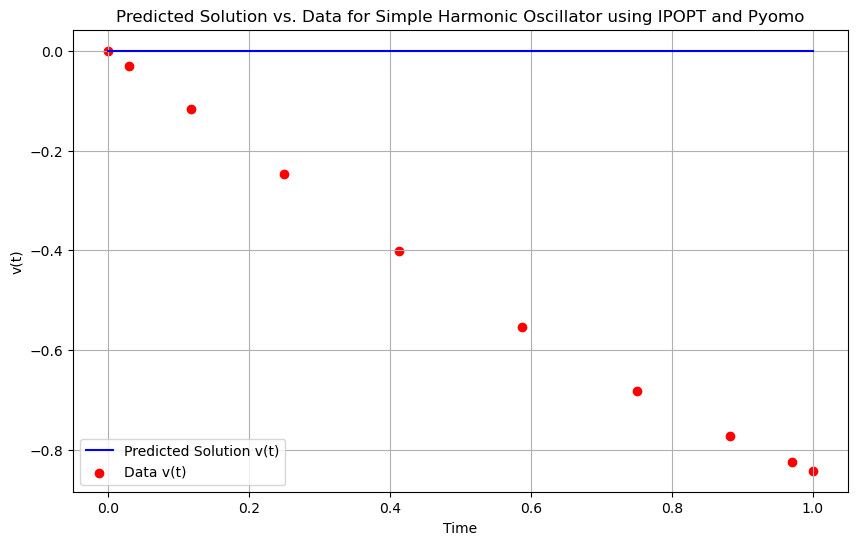

In [44]:
u_solution = np.array([value(neural_net(model, t_grid[i])[0]) for i in model.t_idx])
v_solution = np.array([value(neural_net(model, t_grid[i])[1]) for i in model.t_idx])

sorted_indices = np.argsort(t_grid)
t_grid_sorted = t_grid[sorted_indices]
u_solution_sorted = u_solution[sorted_indices]
v_solution_sorted = v_solution[sorted_indices]

plt.figure(figsize=(10, 6))
plt.plot(t_grid_sorted, u_solution_sorted, label='Predicted Solution u(t)', color='blue')
plt.scatter(t_grid_sorted, data_u[sorted_indices], label='Data u(t)', color='red')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple Harmonic Oscillator using IPOPT and Pyomo')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_grid_sorted, v_solution_sorted, label='Predicted Solution v(t)', color='blue')
plt.scatter(t_grid_sorted, data_v[sorted_indices], label='Data v(t)', color='red')
plt.xlabel('Time')
plt.ylabel('v(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple Harmonic Oscillator using IPOPT and Pyomo')
plt.grid(True)
plt.show()


In [ ]:
#-------------------------------------NODE SET UP----------------------------------#
#-----------------------------------DATA GENERATION--------------------------------#
#------------------------------------COLLOCATION MATRIX----------------------------#
#-----------------------------------MODEL CREATION---------------------------------#
#---------------------------------NEURAL NET PARAMS--------------------------------#
#-----------------------------------FORWARD PASS-----------------------------------#
#--------------------------------INITIAL CONDITIONS--------------------------------#
#------------------------------------CONSTRAINTS-----------------------------------#
#-----------------------------OBJECTIVE FUNCTION DEFINITION------------------------#
#--------------------------------SOLVING THE MODEL---------------------------------#

Attempt a simpler ODE:
### dt_du = −ωu

In [28]:
#---------------------------NODE SET UP--------------------------#
omega = 1.0 # decay
T = 5.0
N = 10

interpolant = BarycentricInterpolation(N, 0, T)
t_grid = np.array(interpolant.nodes)

#---------------------------DATA GENERATION------------------------#
true_u = np.exp(- omega * t_grid)

# Add some noise to simulate real-world data
data_u = true_u + 0.05 * np.random.randn(N)

#---------------------------COLLOCATION MATRIX---------------------#
weights = compute_weights(t_grid)
D = lagrange_derivative(t_grid, weights)
D = np.array(D)

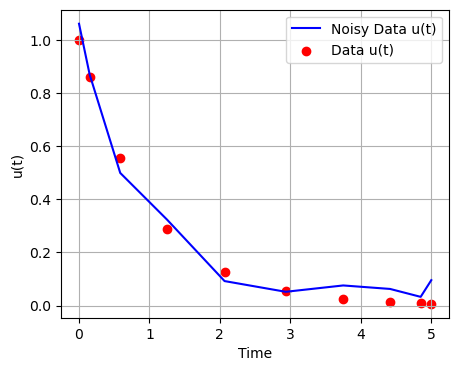

In [29]:
plt.figure(figsize=(5, 4))
plt.plot(t_grid, data_u, label='Noisy Data u(t)', color='blue')
plt.scatter(t_grid, true_u, label='Data u(t)', color='red')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
# plt.title('Predicted Solution vs. Data for Simple Harmonic Oscillator using IPOPT and Pyomo')
plt.grid(True)
plt.show()

In [35]:
#-----------------------------------MODEL CREATION---------------------------------#
n_hidden = 20

model = ConcreteModel()
model.t_idx = RangeSet(0, N-1)

#---------------------------------NEURAL NET PARAMS--------------------------------#
model.W1 = Var(range(n_hidden), initialize=0.1)
model.b1 = Var(initialize=0.1)
model.W2 = Var(range(n_hidden), initialize=0.1)
model.b2 = Var(initialize=0.1)

#-----------------------------------FORWARD PASS-----------------------------------#
def neural_net(m, t):
    z = sum(m.W1[j] * t + m.b1 for j in range(n_hidden))
    a = pyo.tanh(z)
    u = sum(m.W2[j] * a for j in range(n_hidden)) + m.b2
    return u

#--------------------------------INITIAL CONDITIONS--------------------------------#
model.initial_condition = ConstraintList()
model.initial_condition.add(neural_net(model, t_grid[0]) == true_u[0])

#------------------------------------CONSTRAINTS-----------------------------------#
model.ode_constraints = ConstraintList()
for i in model.t_idx:
    u_nn = neural_net(model, t_grid[i])
    
    du_dt = sum(D[i, j] * neural_net(model, t_grid[j]) for j in model.t_idx)
    # neural_net(m, u, t)
    
    model.ode_constraints.add(du_dt == -omega * u_nn)

#-----------------------------OBJECTIVE FUNCTION DEFINITION------------------------#
def _objective(m):
    return sum((neural_net(m, t_grid[i]) - data_u[i])**2 for i in m.t_idx)

model.obj = Objective(rule=_objective, sense=pyo.minimize)

In [36]:
#--------------------------------SOLVING THE MODEL---------------------------------#
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)

if results.solver.termination_condition != pyo.TerminationCondition.optimal:
    print(f"Warning: Solver did not find an optimal solution. Termination condition: {results.solver.termination_condition}")

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:      442
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      903

Total number of variables............................:       42
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       11
Total number

u(t): [1.         0.86004574 0.55716513 0.28650237 0.12670598 0.05317826
 0.02351955 0.01209554 0.00783695 0.00674057]


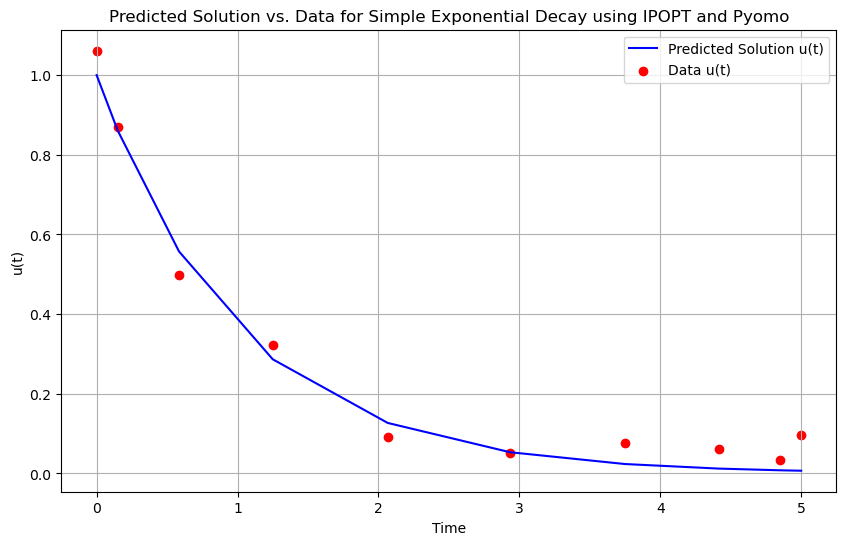

In [37]:
# Extracting Results
u_solution = np.array([value(neural_net(model, t_grid[i])) for i in model.t_idx])

# Print the results
print("u(t):", u_solution)

# Sort the t_grid and corresponding u_solution
sorted_indices = np.argsort(t_grid)
t_grid_sorted = t_grid[sorted_indices]
u_solution_sorted = u_solution[sorted_indices]

# Plotting Results
plt.figure(figsize=(10, 6))
plt.plot(t_grid_sorted, u_solution_sorted, label='Predicted Solution u(t)', color='blue')
plt.scatter(t_grid_sorted, data_u[sorted_indices], label='Data u(t)', color='red')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple Exponential Decay using IPOPT and Pyomo')
plt.grid(True)
plt.show()